In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

import os
import yaml
import wandb
from tqdm import tqdm
from typing import List, Tuple, Callable

import numba
from numba import njit

from keras.datasets import fashion_mnist

## Ques 1 : Loading the Dataset and plotting them

In [2]:
# Loading the dataset
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

# mapping from label to class name
fashion_mnist_label_to_class = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

fashion_mnist_train_df = pd.DataFrame({"image" : list(fashion_mnist_x_train), "label" : fashion_mnist_y_train})
fashion_mnist_test_df = pd.DataFrame({"image" : list(fashion_mnist_x_test), "label" : fashion_mnist_y_test})

print(f"Shape of the train fashion mnist : {fashion_mnist_x_train.shape}")
print(f"Shape of the test fashion mnist : {fashion_mnist_x_test.shape}")

Shape of the train fashion mnist : (60000, 28, 28)
Shape of the test fashion mnist : (10000, 28, 28)


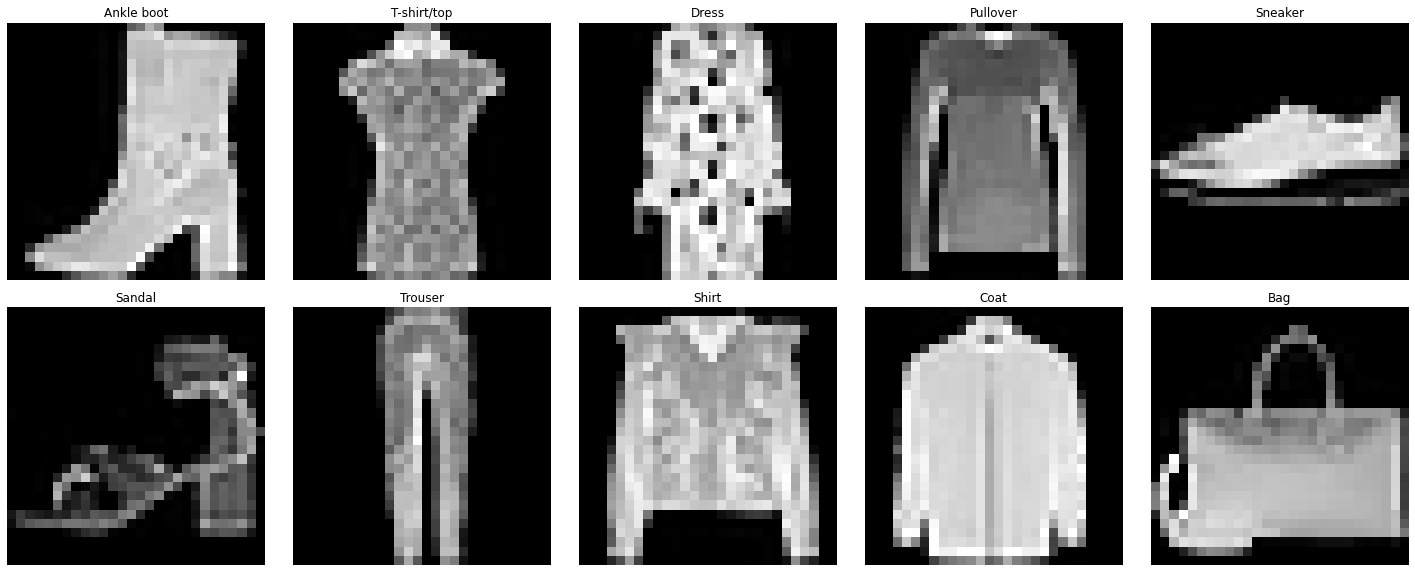

In [3]:
def plot_imag_for_a_label(df):
    unique_labels = df["label"].unique()

    # creating a figure for subplots
    cols = 5
    rows = (len(unique_labels) // (cols)) + 1
    plt.figure(figsize=(20, 12))

    for i, label in enumerate(unique_labels):
        image = df[df["label"] == label].sample(1)["image"]

        # plotting the image
        plt.subplot(rows, cols, i+1)
        plt.imshow(image.values[0], cmap="gray")
        plt.title(fashion_mnist_label_to_class[label])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_imag_for_a_label(fashion_mnist_train_df)

## Ques 2 and Ques 3 : Creating a neural Network

In [4]:
"""
Coding Logic :

    - Similar to PyTorch (Kind of)

    - vectors : 
        - (1,n) dim (column vectors)
        - (batch size, dimension)

    - matrix :
        - (n,m) dimension 
        - matrix multiplication: (batch_size, n) x (n,m) -> (batch_size, m) vector
    
    - Each layer is a class
        - layer can be activation or parameter
        - each layer has a name
        - each layer is identified by the name

"""

'\nCoding Logic :\n\n    - Similar to PyTorch (Kind of)\n\n    - vectors : \n        - (1,n) dim (column vectors)\n        - (batch size, dimension)\n\n    - matrix :\n        - (n,m) dimension \n        - matrix multiplication: (batch_size, n) x (n,m) -> (batch_size, m) vector\n    \n    - Each layer is a class\n        - layer can be activation or parameter\n        - each layer has a name\n        - each layer is identified by the name\n\n'

In [5]:
def xavier_init(n_in, n_out):
    """ Xavier (Glorot) Initialization """
    limit = np.sqrt(6 / (n_in + n_out))  # Computing the limit
    return np.random.uniform(-limit, limit, size=(n_in, n_out)).astype(np.float64)

def random_init_uniform(n_in, n_out):
    """ Random Initialization (Uniform) """
    return np.random.uniform(-1, 1, size=(n_in, n_out)).astype(np.float64)

In [6]:
x = np.array([[1,2,3],[1,2,3]])
# x = x.reshape(1,-1)
# np.hstack([x,np.array([[1]])])
np.concatenate( [x,np.ones(shape = (x.shape[0],1), dtype = np.float64)] , axis = 1)

array([[1., 2., 3., 1.],
       [1., 2., 3., 1.]])

### Linear layer

In [7]:
class Layer_Info():
    @property
    def is_activation(self): 
        return self._is_activation

    @property
    def layer_name(self):
        return self._name

    @property
    def layer_type(self):
        return self._layer_type

@njit
def matrix_mul(x,y):
    x = np.ascontiguousarray(x)
    y = np.ascontiguousarray(y) 
    return x@y

class Linear(Layer_Info):
    def __init__(self, input_dim : int, 
                       output_dim : int, 
                       initializer_function : Callable = xavier_init,
                       bias : bool = True,
                       name = "default_name"):

        # getting the weights of the network (adding one more input for bias)
        self.input_dim = input_dim + int(bias)
        self.output_dim = output_dim
        self.w = initializer_function(self.input_dim, self.output_dim)

        # other necessary variables for the info the layer
        self.is_bias = bias
        self._name = name
        self._layer_type = "Linear"
        self._is_activation = False

        # variables for gradients and used by optimizers
        self.dw = np.zeros(shape = self.w.shape, dtype = np.float64)
        self.optimizer_variables = {} # -> This is important thing used used by the optimizers for updating the weights
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # changing the dtype and adding the input for the bias
        self.x = x.astype(np.float64)
        if self.is_bias: self.x = np.concatenate((self.x,np.ones(shape = (x.shape[0],1), dtype = np.float64)), axis = 1)

        # returning the matrix multiplication
        # raise Exception(f"""Test 1 : print under forward of linear , input_shape : {self.x.shape} , weight_shape : {self.w.shape}
        #                 output_shape : {(self.x@self.w).shape}""") # -> Test passed
    
        # return self.x@self.w
        return matrix_mul(self.x,self.w)
        
    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # updating the gradient for weights and x
        # self.dw = self.x.T@prev_grad
        # self.dx = prev_grad@self.w.T
        self.dw = matrix_mul(self.x.T,prev_grad)
        self.dx = matrix_mul(prev_grad,self.w.T)
        if self.is_bias: self.dx = self.dx[:,:-1] #( We have to remove the extra bias term we have added for calculation)

        # this will be used by the optimizer
        self.optimizer_variables['dw'] = self.dw
        self.optimizer_variables['dx'] = self.dx

        return self.dx
    
    def step(self, optimizer):
        # for updating the values
        optimizer.update_params(self)

In [8]:
linear_layer = Linear(10,20,xavier_init)
linear_layer.forward(np.ones((15,10))).shape
linear_layer.backward(np.ones((15,20))).shape

(15, 10)

### Activation functions

In [9]:
class Sigmoid(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._layer_type = "Sigmoid"
        self._is_activation = True
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        x = np.clip(x, -100, 100)
        self.output = np.where( x >= 0, 1 / (1 + np.exp(-x)),  np.exp(x) / (1 + np.exp(x)) )
        # raise Exception(f"Test 2 : Inside the sigmoid act fn , output shape : {self.output.shape}") 
        return self.output

    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # updating the gradient for x (using hadamard product)
        self.dx = prev_grad*self.output*(1 - self.output)
        return self.dx
    

class Tanh(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._layer_type = "Tanh"
        self._is_activation = True
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        self.output = np.tanh(self.x)
        # self.output = np.where( x >= 0, (1 - np.exp(-2*x))/(np.exp(-2*x) + 1),  (np.exp(2*x) - 1)/(1 + np.exp(2*x)) )
        # raise Exception(f"Test 3 : Inside the Tanh act fn , output shape : {self.output.shape}")
        return self.output

    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        # updating the gradient for x (using hadamard product)
        self.dx = prev_grad*(1 - self.output**2)
        return self.dx

class ReLU(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._layer_type = "ReLU"
        self._is_activation = True
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        self.output = np.maximum(x,0)
        # raise Exception(f"Test 4 : Inside the ReLU act fn , output shape : {self.output.shape}") # -> passed
        return self.output

    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        # updating the gradient for x (using hadamard product)
        self.dx = prev_grad*(self.output > 0)
        return self.dx

In [10]:
sig = Sigmoid()
x = np.random.randint(-1,100000,size = (15,10)).astype(np.float64)
sig.forward(x)
sig.backward(np.ones(shape = (15,10))).shape

(15, 10)

In [11]:
# gr = -1000000000
# (np.exp(2*gr) - 1) / (1 + np.exp(2*gr))

# for i in x:
#         for j in i:
#                 np.where( j >= 0,
#                         (1 - np.exp(-2*j)) / (np.exp(-2*j) + 1),  
#                         (np.exp(2*j) - 1) / (1 + np.exp(2*j))   
#                         )
#                 print(j)
# np.where( j >= 0,
#         -10,  
#         (np.exp(2*j) - 1) / (1 + np.exp(2*j))   
#         )

np.tanh(x)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

### Loss functions

In [12]:
class softmax_cross_entropy(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._is_activation = False
        self._layer_type = "Softmax-with-Cross-Entropy"
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        x_max = np.max(x, axis=1, keepdims=True)  # size -> (batch_size, 1)
        exp_x = np.exp(x - x_max)  # Subtract max for numerical stability
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True) # normalizing along the axis
        # raise Exception(f"Test 5 : Inside the Softmax Cross entropy , output shape : {self.output.shape}") # -> passed
        return self.output

    def calculate_loss(self, y_true : npt.NDArray[np.float64]) -> float:
        self.loss = np.sum(-np.log(self.output + 1e-10)*y_true, axis = 1)
        return np.mean(self.loss)

    def backward(self, y_true : npt.NDArray[np.float64]) -> npt.NDArray[np.float64] :
        self.dx = -(y_true - self.output)
        return self.dx

class L2_Loss(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._is_activation = False
        self._layer_type = "L2-Loss"
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        self.x = x
        self.output = self.x.copy()
        return self.output

    def calculate_loss(self, y_true : npt.NDArray[np.float64]) -> float:
        self.loss = np.mean((y_true - self.output)**2, axis = 1)
        return np.mean(self.loss)

    def backward(self, y_true : npt.NDArray[np.float64])  -> npt.NDArray[np.float64] :
        self.dx = -(y_true - self.output)
        return self.dx

class Sigmoid_with_BCE(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._is_activation = False
        self._layer_type = "Softmax-with-Cross-Entropy"
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        raise NotImplementedError("Question didn't ask for it, so haven't implemented, just defined for namesake")

    def backward(self, y_true : npt.NDArray[np.float64])  -> npt.NDArray[np.float64] :
        raise NotImplementedError("Question didn't ask for it, so haven't implemented, just defined for namesake")

In [13]:
softmax_test = L2_Loss()
softmax_test.forward(np.random.normal(size = (5,10)))
fake_true = np.random.randint(0,2, size = (5,10))
softmax_test.calculate_loss(y_true = fake_true)

1.918964175443482

### optimizers

In [14]:
class optimizer_info():
    @property
    def learning_rate(self):
        return self.lr

    @property
    def optimizer_type(self):
        return self._optimizer_type

    @property
    def optimizer_name(self):
        return self._name
    
    @property
    def specification(self):
        return self._specification

    def __str__(self):
        s = f"These are the specifications of the optimizer : '{self._optimizer_type}' \n"
        s += "\n".join([f"{str(x)} : {str(y)}" for x,y in self._specification.items()])
        return s

class SGD(optimizer_info):
    def __init__(self, lr : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        self._name = name
        self._optimizer_type = "SGD"

        self.lr = lr
        self.weight_decay = weight_decay

        self._specification = {"lr" : lr, "weight_decay": weight_decay} # This will tell what are the specifications of different optimizers
    
    def update_params(self, obj : Linear):

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w

        # updating the parameters here
        obj.w -= self.lr*dw

class GD_Momentum(optimizer_info):
    def __init__(self, lr : float, 
                       beta : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "GD_with_Momentum"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta = beta

        self._specification = {"lr" : self.lr, "beta" : self.beta, "weight_decay" : weight_decay,
                               "du" : "previous gradients updates for momentum"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']
        if "du" not in obj.optimizer_variables: 
            obj.optimizer_variables['du'] = np.zeros(shape = dw.shape, dtype = np.float64)
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        ut = (self.beta)*obj.optimizer_variables['du'] + dw

        # updating the parameters here and optimizer variables
        obj.w -= self.lr*ut
        obj.optimizer_variables['du'] = ut

class NAG(optimizer_info):
    def __init__(self, lr : float, 
                       beta : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "NAG"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta = beta

        self._specification = {"lr" : self.lr, "beta" : self.beta, "weight_decay" : weight_decay, "du" : "previous gradients updates for momentum"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']
        if "du" not in obj.optimizer_variables: 
            obj.optimizer_variables['du'] = np.zeros(shape = dw.shape, dtype = np.float64)
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        ut = (self.beta)*obj.optimizer_variables['du'] + dw

        # updating the parameters here and optimizer variables
        obj.w += -(self.lr*dw) - (self.lr*self.beta*ut)
        obj.optimizer_variables['du'] = ut

class RMSprop(optimizer_info):
    def __init__(self, lr : float, 
                       beta : float,
                       epsilon : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "RMSprop"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta = beta
        self.epsilon = epsilon

        self._specification = {"lr" : self.lr, 
                               "beta" : self.beta, 
                               "epsilon" : self.epsilon,
                               "weight_decay" : weight_decay,
                               "dv" : "cumulative square of gradients"} # This will tell what are the specifications of different optimizers

    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']
        if "dv" not in obj.optimizer_variables: 
            obj.optimizer_variables['dv'] = np.zeros(shape = dw.shape, dtype = np.float64)
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        vt = (self.beta)*obj.optimizer_variables['dv'] + (1 - self.beta)*(dw**2)

        # updating the parameters here and optimizer variables
        obj.w -= (self.lr)*(dw)/((vt + self.epsilon)**0.5)
        obj.optimizer_variables['dv'] = vt

class Adam(optimizer_info):
    def __init__(self, lr : float, 
                       beta1 : float,
                       beta2 : float,
                       epsilon : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "Adam"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self._specification = {"lr" : self.lr, 
                               "beta1" : self.beta1, 
                               "beta2" : self.beta2,
                               "epsilon" : self.epsilon,
                               "weight_decay" : weight_decay,
                               "dm" : "classical momentum",
                               "dv" : "cumulative square of gradients"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']

        if "dv" not in obj.optimizer_variables: 
            obj.optimizer_variables['dv'] = np.zeros(shape = dw.shape, dtype = np.float64)

        if "dm" not in obj.optimizer_variables: 
            obj.optimizer_variables['dm'] = np.zeros(shape = dw.shape, dtype = np.float64)
        
        if "beta1^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta1^t'] = self.beta1

        if "beta2^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta2^t'] = self.beta2
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        mt = (self.beta1)*obj.optimizer_variables['dm'] +  (1 - self.beta1)*(dw)
        vt = (self.beta2)*obj.optimizer_variables['dv'] + (1 - self.beta2)*(dw**2)
        beta1_t = obj.optimizer_variables['beta1^t']
        beta2_t = obj.optimizer_variables['beta2^t']

        mt_normalized = mt/(1 - beta1_t)
        vt_normalized = vt/(1 - beta2_t)

        # updating the parameters here and optimizer variables
        obj.w -= (self.lr)*(mt_normalized)/((vt_normalized**0.5) + self.epsilon)

        obj.optimizer_variables['dv'] = vt
        obj.optimizer_variables['dm'] = mt
        obj.optimizer_variables['beta1^t'] = self.beta1*beta1_t
        obj.optimizer_variables['beta2^t'] = self.beta2*beta2_t

class Nadam(optimizer_info):
    def __init__(self, lr : float, 
                       beta1 : float,
                       beta2 : float,
                       epsilon : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "Nadam"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self._specification = {"lr" : self.lr, 
                               "beta1" : self.beta1, 
                               "beta2" : self.beta2,
                               "epsilon" : self.epsilon,
                               "weight_decay" : weight_decay,
                               "dm" : "classical momentum",
                               "dv" : "cumulative square of gradients"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']

        if "dv" not in obj.optimizer_variables: 
            obj.optimizer_variables['dv'] = np.zeros(shape = dw.shape, dtype = np.float64)

        if "dm" not in obj.optimizer_variables: 
            obj.optimizer_variables['dm'] = np.zeros(shape = dw.shape, dtype = np.float64)
        
        if "beta1^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta1^t'] = self.beta1

        if "beta2^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta2^t'] = self.beta2
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        mt = (self.beta1)*obj.optimizer_variables['dm'] +  (1 - self.beta1)*(dw)
        vt = (self.beta2)*obj.optimizer_variables['dv'] + (1 - self.beta2)*(dw**2)
        beta1_t = obj.optimizer_variables['beta1^t']
        beta2_t = obj.optimizer_variables['beta2^t']

        mt_normalized = mt/(1 - beta1_t)
        vt_normalized = vt/(1 - beta2_t)

        # updating the parameters here and optimizer variables
        obj.w -= (self.lr)*((self.beta1*mt_normalized) + (1-self.beta1)*dw/(1 - beta1_t) )/((vt_normalized**0.5) + self.epsilon)

        obj.optimizer_variables['dv'] = vt
        obj.optimizer_variables['dm'] = mt
        obj.optimizer_variables['beta1^t'] = self.beta1*beta1_t
        obj.optimizer_variables['beta2^t'] = self.beta2*beta2_t

In [15]:
gd = Nadam(1,1,1,1,1)
print(gd)

These are the specifications of the optimizer : 'Nadam' 
lr : 1
beta1 : 1
beta2 : 1
epsilon : 1
weight_decay : 1
dm : classical momentum
dv : cumulative square of gradients


### Building a Neural Network

In [16]:
class NN():
    def __init__(self, arch : List[Linear | Sigmoid | Tanh | ReLU],
                       optimizer,
                       optimizer_params : dict,
                       Loss : softmax_cross_entropy | L2_Loss | None,
                       arch_name : str = "default_name"):
        
        # Architecture is a series of layers 
        self.arch = arch
        self.arch_name = arch_name
        self.optimizer_params = optimizer_params
        self.optimizer = optimizer(**self.optimizer_params)
        self.Loss = Loss

        # other variables for the network
        self.total_parameters = -1

    @property
    def parameters_count(self):
        self.total_parameters = 0
        
        for layer in self.arch:
            if layer.is_activation == False: 
                self.total_parameters += (layer.w.shape[0] * layer.w.shape[1])
        
        return self.total_parameters

    def forward(self, input : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        # passing through all layers in the architecture
        curr_output = input
        
        for i,layer in enumerate(self.arch):
            curr_output = layer.forward(curr_output)

            # updating names, if names are not given
            if layer.layer_name == "default_name": layer._name = f"{layer.layer_type} : {i+1}"

        # finally passing through the output for the Loss (this is not the loss, just the activation fn for the loss)
        output = self.Loss.forward(curr_output) if self.Loss != None else curr_output

        return output
    
    def calculate_loss(self, y_true : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        return self.Loss.calculate_loss(y_true)

    def backward(self, y_true : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # getting the gradient from the Loss
        prev_layer_grad = self.Loss.backward(y_true)

        # backward pass through all layers (iterating in opposite direction)
        for layer in self.arch[::-1]:
            # print(prev_layer_grad.shape)
            prev_layer_grad = layer.backward(prev_layer_grad)
    
    def step(self,):
        # updating the layer parameters if it is not activation layer
        for layer in self.arch[::-1]:
            if layer.is_activation == False: 
                layer.step(self.optimizer)

In [17]:
example_arch_1 = [Linear(28*28,64), Linear(64,64), ReLU(), Linear(64,64), Tanh(), Linear(64,10)]
example_loss = softmax_cross_entropy()
example_optimizer_params = {"lr" : 1e-4, 
                            "beta1" : 0.9, 
                            "beta2" : 0.99,
                            "epsilon" : 1e-7,
                            "weight_decay" : 0,}

example_nn = NN(arch = example_arch_1, 
                optimizer = Adam, 
                optimizer_params = example_optimizer_params,
                Loss = example_loss,
                arch_name = "example_arch_1")

print(f" total params : {example_nn.parameters_count} " )
example_nn.forward(np.ones((15,28*28))).shape
example_nn.backward(np.ones((15,10)))
example_nn.step()
example_nn.calculate_loss(np.ones((15,10)))

 total params : 59210 


25.182256740309086

### Building Training Loop

In [18]:
class Training_Loop():
    def __init__(self, train_x : npt.NDArray, train_y : npt.NDArray,
                       val_x : npt.NDArray, val_y : npt.NDArray, 
                       Network : NN,):
        
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.network = Network
    
    def batch_generator(self, X, Y, batch_size, shuffle=True):
        num_samples = X.shape[0]
        indices = np.arange(num_samples)

        if shuffle:
            np.random.shuffle(indices)  # Shuffle indices for randomness

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            yield X[batch_indices], Y[batch_indices]

    def train(self, epochs : int, batch_size : int) -> dict:

        total_train_loss = []
        total_train_accuracy = []

        total_validation_loss = []
        total_validation_accuracy = []  

        desc = ""
        loop_obj = range(epochs)
        for e in loop_obj:

            epoch_loss = 0
            epoch_correct = 0

            # Train loop of the model
            for X_batch, Y_true in tqdm(self.batch_generator(self.train_x, self.train_y, batch_size), desc = f"train-progress-bar , epcoh : {e+1}"):

                # getting the output
                Y_pred = self.network.forward(X_batch)
                epoch_loss += self.network.calculate_loss(Y_true)

                # updating the parameters
                self.network.backward(y_true = Y_true)
                self.network.step()

                # getting the total number of correct answers
                Y_pred_class = np.argmax(Y_pred, axis = 1)
                Y_true_class = np.argmax(Y_true, axis = 1)
                epoch_correct += np.sum(Y_pred_class == Y_true_class)
            
            total_train_loss.append(epoch_loss)
            total_train_accuracy.append(epoch_correct/self.train_x.shape[0])

            # Validation loop of the model
            epoch_loss_val = 0
            epoch_correct_val = 0
            for X_batch, Y_true in self.batch_generator(self.val_x, self.val_y, batch_size):

                # getting the output
                Y_pred = self.network.forward(X_batch)
                epoch_loss_val += self.network.calculate_loss(Y_true)

                # getting the total number of correct answers
                Y_pred_class = np.argmax(Y_pred, axis = 1)
                Y_true_class = np.argmax(Y_true, axis = 1)
                epoch_correct_val += np.sum(Y_pred_class == Y_true_class)
            
            total_validation_loss.append(epoch_loss_val)
            total_validation_accuracy.append(epoch_correct_val/self.val_x.shape[0])

            # updating desc for tqdm
            desc = f"Train error : {epoch_loss:.4f} ; Train acc : {(epoch_correct/self.train_x.shape[0]):.4f} ; val error : {epoch_loss_val:.4f}  ; val acc : {(epoch_correct_val/self.val_x.shape[0]):.4f} \n"
            # print(desc)
            # loop_obj.set_description(desc)

        stats = {"Train_loss" : total_train_loss,
                 "Train_accuracy" : total_train_accuracy,
                 "Validation_loss" : total_validation_loss,
                 "Validation_accuracy" : total_validation_accuracy}

        return stats

#### processing data for training

In [19]:
def one_hot_encode(Y, num_classes=10):
    
    num_samples = Y.shape[0]
    Y_one_hot = np.zeros((num_samples, num_classes), dtype=np.float64)
    Y_one_hot[np.arange(num_samples), Y] = 1  
    return Y_one_hot.astype(np.float64)

def train_val_split(X, Y, train_ratio=0.9, seed=None):
    X = X.astype(np.float64)
    num_samples = X.shape[0]
    indices = np.arange(num_samples)

    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility
    np.random.shuffle(indices)  # Shuffle dataset indices

    train_size = int(num_samples * train_ratio)
    val_size = num_samples - train_size
    train_idx, val_idx = indices[:train_size], indices[train_size:]

    return X[train_idx].reshape(train_size,-1), one_hot_encode(Y[train_idx]), X[val_idx].reshape(val_size,-1), one_hot_encode(Y[val_idx])

Train_fashion_Mnist_X, Train_fashion_Mnist_Y, Val_fashion_Mnist_X, Val_fashion_Mnist_Y = train_val_split(fashion_mnist_x_train, fashion_mnist_y_train, 0.9, 100)

#### training network

In [20]:
# Initializing the training class
model_arch_1 = [Linear(28*28,128), Linear(128,128), ReLU(), Linear(128,128), ReLU(), Linear(128,128), ReLU(), Linear(128,64), ReLU(), Linear(64,10)]
model_loss_1 = softmax_cross_entropy()
model_optimizer_params_1 = {"lr" : 1e-3, 
                            "beta1" : 0.9, 
                            "beta2" : 0.999,
                            "epsilon" : 1e-7,
                            "weight_decay" : 0,}

model_nn_1 = NN(arch = model_arch_1, 
                optimizer = SGD, 
                optimizer_params = model_optimizer_params_1,
                Loss = model_loss_1,
                arch_name = "model_arch_1")

print(f"Total model parameters : {model_nn_1.parameters_count*1e-3} K \n")

print(f"Outputting the probabilities of the network for sample data : {model_nn_1.forward(Train_fashion_Mnist_X[0:1])}")

Total model parameters : 158.922 K 

Outputting the probabilities of the network for sample data : [[3.61571576e-06 2.67473959e-32 2.23512662e-30 1.28156536e-23
  5.23111798e-45 1.07223301e-36 1.42811020e-49 1.06641056e-45
  8.13940135e-27 9.99996384e-01]]


In [21]:
train_loop_1 = Training_Loop(train_x = Train_fashion_Mnist_X,
                             train_y = Train_fashion_Mnist_Y,
                             val_x = Val_fashion_Mnist_X,
                             val_y = Val_fashion_Mnist_Y,
                             Network = model_nn_1)

model_1_history = train_loop_1.train(epochs = 5, batch_size = 32)

train-progress-bar , epcoh : 1: 1688it [00:14, 119.97it/s]
train-progress-bar , epcoh : 2: 1688it [00:13, 122.60it/s]
train-progress-bar , epcoh : 3: 1688it [00:13, 123.74it/s]
train-progress-bar , epcoh : 4: 1688it [00:14, 119.18it/s]
train-progress-bar , epcoh : 5: 1688it [00:13, 122.44it/s]


In [22]:
model_1_history['validation_accuracy']

KeyError: 'validation_accuracy'

## Ques 4 

### creating automated trainer

In [43]:
class automated_trainer():
    def __init__(self, 
                 input_size : int = 28*28,
                 output_size : int = 10,
                 epochs : int = 5,
                 n_hidden : int = 3,
                 hidden_size : int = 32,
                 weight_decay : float = 0,
                 lr : float = 1e-3,
                 optimizer : str = "adam",
                 batch_size : int = 16,
                 weight_initialization : str = "xavier",
                 activation_fn : str = "relu",
                 beta : float = 0.9,
                 beta1 : float = 0.9,
                 beta2 : float = 0.999,
                 epsilon : float = 1e-7,
                 loss : str = "cross-entropy" ,
                ):
        
        self.epochs = epochs
        self.batch_size = batch_size
        # self.n_hidden = n_hidden

        # getting the init fn
        self.initializer_map = {'xavier' : xavier_init, 'random' : random_init_uniform}
        self.init_fn = self.initializer_map[weight_initialization]

        # getting the activation fn
        self.activation_fn_map = {"sigmoid" : Sigmoid, "tanh" : Tanh, "relu" : ReLU}
        self.act_fn = self.activation_fn_map[activation_fn]

        # for optimizer and loading the optimizer
        self.optimizer_map = {"sgd" : SGD, "momentum" : GD_Momentum, "nesterov" : NAG, 
                              "rmsprop" : RMSprop, "adam" : Adam, "nadam" : Nadam}
        self.optimizer_params = {"lr" : lr, "weight_decay" : weight_decay, "beta" : beta, 
                                 "beta1" : beta1, "beta2" : beta2, "epsilon" : epsilon}
        
        self.optimizer_class = self.optimizer_map[optimizer]
        print(f"optimizer loaded with this setting : \n{self.optimizer_class(**self.optimizer_params)} \n")

        # loading the loss function
        self.loss_map = {"cross-entropy" : softmax_cross_entropy, "L2" : L2_Loss}
        self.loss_class = self.loss_map[loss]

        # creating nn
        self.__make_nn__(input_size = input_size, output_size = output_size, n_hidden = n_hidden, hidden_size = hidden_size)

        # creating the trainer
        self.trainer = Training_Loop(train_x = Train_fashion_Mnist_X,
                                    train_y = Train_fashion_Mnist_Y,
                                    val_x = Val_fashion_Mnist_X,
                                    val_y = Val_fashion_Mnist_Y,
                                    Network = self.nn)

    def __make_nn__(self, input_size, n_hidden, hidden_size, output_size,):

        arch = [ Linear(input_dim = input_size, output_dim = hidden_size, initializer_function = self.init_fn) ]

        # creating the network
        for i in range(n_hidden):
            arch.append(self.act_fn())
            arch.append(Linear(input_dim = hidden_size, output_dim = hidden_size, initializer_function = self.init_fn))
        
        arch.append(self.act_fn())
        arch.append(Linear(input_dim = hidden_size, output_dim = output_size, initializer_function = self.init_fn))
    

        self.nn = NN(arch = arch, optimizer = self.optimizer_class, 
                     optimizer_params = self.optimizer_params, Loss = self.loss_class())
        
        print(f"NN created successfully !, total params : {self.nn.parameters_count*1e-3:.3f}K \n")
    
    def train_network(self):
        stats = self.trainer.train(epochs = self.epochs,
                           batch_size = self.batch_size,)
        return stats

In [53]:
## checking automated trainer
Automated_trainer_1 = automated_trainer(optimizer = 'nadam', lr = 1e-3, weight_decay = 0.5, activation_fn='sigmoid')
Automated_trainer_1.train_network()

# passed works well

optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 28.618K 



train-progress-bar , epcoh : 1: 3375it [00:02, 1304.18it/s]
train-progress-bar , epcoh : 2: 3375it [00:02, 1359.73it/s]
train-progress-bar , epcoh : 3: 3375it [00:02, 1319.45it/s]
train-progress-bar , epcoh : 4: 3375it [00:02, 1367.19it/s]
train-progress-bar , epcoh : 5: 3375it [00:02, 1400.77it/s]


{'Train_loss': [7788.898229703835,
  7780.790878985427,
  7782.250927701389,
  7781.214464408212,
  7780.092347253768],
 'Train_accuracy': [0.09822222222222222,
  0.10135185185185185,
  0.09807407407407408,
  0.10044444444444445,
  0.10022222222222223],
 'Validation_loss': [864.8376848873793,
  864.656573108268,
  863.7900847532273,
  864.2159330841963,
  864.959817633053],
 'Validation_accuracy': [0.10183333333333333, 0.1015, 0.1, 0.1015, 0.0985]}

### Wandb sweep 

In [48]:
# sweep_config = {
#     "method": "bayes",  # You can use "grid" or "bayes" as well
#     "metric": {
#         "name": "val_accuracy",  # or "accuracy", depending on what you log
#         "goal": "maximize"
#     },
#     "parameters": {
#         "epochs": {
#             "values": [5, 10]
#         },
#         "n_hidden": {
#             "values": [3, 4, 5]
#         },
#         "hidden_size": {
#             "values": [32, 64, 128]
#         },
#         "weight_decay": {
#             "values": [0, 0.0005, 0.5]
#         },
#         "lr": {
#             "values": [1e-3, 1e-4]
#         },
#         "optimizer": {
#             "values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
#         },
#         "batch_size": {
#             "values": [16, 32, 64]
#         },
#         "weight_initialization": {
#             "values": ["random", "xavier"]
#         },
#         "activation_fn": {
#             "values": ["sigmoid", "tanh", "relu"]
#         }
#     }
# }

# loading from yaml file
with open('sweep_config.yaml','r') as f:
    sweep_config = yaml.safe_load(f)

# logging in into wandb
wandb.login(key="878d8077f96e35def15932addea71a0302e0dede")

def train_with_wandb():

    run = wandb.init()
    config = wandb.config
    run.name = f"act_fn : {config.activation_fn} _ hidden : {config.n_hidden}-{config.hidden_size} _ optimizer : {config.optimizer} "

    # creating trainer
    trainer_wandb = automated_trainer(**dict(config))
    stats = trainer_wandb.train_network()

    for i in range(0,len(stats['Train_loss'])):

        wandb.log({
                "epoch": i,
                "train_accuracy" : stats['Train_accuracy'][i],
                "train_loss": stats['Train_loss'][i],
                "val_loss" : stats['Validation_loss'][i],
                "val_accuracy": stats['Validation_accuracy'][i],
            })

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\pcdpm\_netrc


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DA6401-fashion-mnist-assig-1")
wandb.agent(sweep_id, function=train_with_wandb)

Create sweep with ID: m9q1iw6o
Sweep URL: https://wandb.ai/shivasurya-iit-madras/DA6401-fashion-mnist-assig-1/sweeps/m9q1iw6o


wandb: Agent Starting Run: j122wo7b with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 29.674K 



train-progress-bar , epcoh : 1: 3375it [00:02, 1396.23it/s]
train-progress-bar , epcoh : 2: 3375it [00:02, 1142.82it/s]
train-progress-bar , epcoh : 3: 3375it [00:03, 1118.52it/s]
train-progress-bar , epcoh : 4: 3375it [00:03, 933.16it/s] 
train-progress-bar , epcoh : 5: 3375it [00:03, 1061.07it/s]


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▇▆█
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.44504
train_loss,4143.3888
val_accuracy,0.4665
val_loss,444.68757


wandb: Agent Starting Run: 8psed2rr with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'SGD' 
lr : 0.0001
weight_decay : 0.5 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 3375it [00:10, 334.61it/s]
train-progress-bar , epcoh : 2: 3375it [00:06, 520.88it/s]
train-progress-bar , epcoh : 3: 3375it [00:06, 516.43it/s]
train-progress-bar , epcoh : 4: 3375it [00:08, 396.71it/s]
train-progress-bar , epcoh : 5: 3375it [00:07, 476.21it/s]
train-progress-bar , epcoh : 6: 3375it [00:07, 471.47it/s]
train-progress-bar , epcoh : 7: 3375it [00:06, 537.74it/s]
train-progress-bar , epcoh : 8: 3375it [00:06, 494.89it/s]
train-progress-bar , epcoh : 9: 3375it [00:06, 526.24it/s]
train-progress-bar , epcoh : 10: 3375it [00:06, 487.65it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆██▇
val_loss,█▄▃▃▂▃▂▁▁▁
epoch,9
train_accuracy,0.69422
train_loss,2828.03002
val_accuracy,0.6915
val_loss,317.67306


wandb: Agent Starting Run: 97t723w2 with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'NAG' 
lr : 0.001
beta : 0.9
weight_decay : 0.0005
du : previous gradients updates for momentum 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 3375it [00:11, 292.90it/s]
train-progress-bar , epcoh : 2: 3375it [00:14, 240.83it/s]
train-progress-bar , epcoh : 3: 3375it [00:12, 280.15it/s]
train-progress-bar , epcoh : 4: 3375it [00:09, 341.92it/s]
train-progress-bar , epcoh : 5: 3375it [00:10, 331.01it/s]
train-progress-bar , epcoh : 6: 3375it [00:14, 225.66it/s]
train-progress-bar , epcoh : 7: 3375it [00:13, 248.55it/s]
train-progress-bar , epcoh : 8: 3375it [00:12, 264.42it/s]
train-progress-bar , epcoh : 9: 3375it [00:11, 288.91it/s]
train-progress-bar , epcoh : 10: 3375it [00:11, 297.73it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▆▇██▆▁▂▃▃
train_loss,▅▃▂▁▂▃█▆▄▄
val_accuracy,▃█▇█▆▆▁▂▃▃
val_loss,▅▁▁▁▃▃█▄▅▄
epoch,9
train_accuracy,0.19498
train_loss,6254.69239
val_accuracy,0.18817
val_loss,684.91721


wandb: Agent Starting Run: paxgkl0t with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'GD_with_Momentum' 
lr : 0.0001
beta : 0.9
weight_decay : 0.0005
du : previous gradients updates for momentum 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:04, 186.98it/s]
train-progress-bar , epcoh : 2: 844it [00:03, 249.27it/s]
train-progress-bar , epcoh : 3: 844it [00:03, 219.61it/s]
train-progress-bar , epcoh : 4: 844it [00:03, 224.85it/s]
train-progress-bar , epcoh : 5: 844it [00:03, 219.53it/s]
train-progress-bar , epcoh : 6: 844it [00:04, 187.20it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 135.08it/s]
train-progress-bar , epcoh : 8: 844it [00:04, 191.77it/s]
train-progress-bar , epcoh : 9: 844it [00:04, 201.41it/s]
train-progress-bar , epcoh : 10: 844it [00:04, 189.17it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▃▂▃▇▆▅▁▄
train_loss,▂█▄▇▆▁▁▂▅▄
val_accuracy,▄█▁▄▄▇█▄▅▇
val_loss,▄▂█▄▄▁▁▄▃▁
epoch,9
train_accuracy,0.25785
train_loss,1441.85352
val_accuracy,0.282
val_loss,146.89487


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2swkimbj with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 1688it [00:05, 291.13it/s]
train-progress-bar , epcoh : 2: 1688it [00:05, 286.57it/s]
train-progress-bar , epcoh : 3: 1688it [00:06, 261.51it/s]
train-progress-bar , epcoh : 4: 1688it [00:08, 199.09it/s]
train-progress-bar , epcoh : 5: 1688it [00:07, 230.93it/s]


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.57124
train_loss,1849.67986
val_accuracy,0.59667
val_loss,196.08127


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n4trp9ao with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:03, 231.00it/s]
train-progress-bar , epcoh : 2: 844it [00:03, 235.73it/s]
train-progress-bar , epcoh : 3: 844it [00:03, 212.44it/s]
train-progress-bar , epcoh : 4: 844it [00:04, 201.18it/s]
train-progress-bar , epcoh : 5: 844it [00:03, 232.31it/s]
train-progress-bar , epcoh : 6: 844it [00:04, 177.53it/s]
train-progress-bar , epcoh : 7: 844it [00:03, 221.79it/s]
train-progress-bar , epcoh : 8: 844it [00:03, 233.72it/s]
train-progress-bar , epcoh : 9: 844it [00:03, 221.02it/s]
train-progress-bar , epcoh : 10: 844it [00:03, 232.56it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▆▃▅▄▁▅▅█▆▄
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▇▁▇▆█▆▇▃█▆
val_loss,▄▂▄▂█▃▅▄▂▁
epoch,9
train_accuracy,0.09828
train_loss,1943.83985
val_accuracy,0.10067
val_loss,216.437


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dnhpwdrg with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'SGD' 
lr : 0.0001
weight_decay : 0.5 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 3375it [00:07, 451.13it/s]
train-progress-bar , epcoh : 2: 3375it [00:07, 473.27it/s]
train-progress-bar , epcoh : 3: 3375it [00:07, 457.74it/s]
train-progress-bar , epcoh : 4: 3375it [00:07, 448.21it/s]
train-progress-bar , epcoh : 5: 3375it [00:06, 485.06it/s]
train-progress-bar , epcoh : 6: 3375it [00:08, 420.00it/s]
train-progress-bar , epcoh : 7: 3375it [00:07, 481.22it/s]
train-progress-bar , epcoh : 8: 3375it [00:08, 408.21it/s]
train-progress-bar , epcoh : 9: 3375it [00:08, 401.89it/s]
train-progress-bar , epcoh : 10: 3375it [00:07, 463.65it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇██▇
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.68763
train_loss,2836.34224
val_accuracy,0.67333
val_loss,319.64877


wandb: Agent Starting Run: uszumvx2 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'SGD' 
lr : 0.0001
weight_decay : 0.5 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 0it [00:00, ?it/s]C:\Users\pcdpm\AppData\Local\Temp\ipykernel_17576\3184334230.py:12: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - x_max)  # Subtract max for numerical stability
train-progress-bar , epcoh : 1: 3375it [00:02, 1613.95it/s]
train-progress-bar , epcoh : 2: 3375it [00:01, 1847.33it/s]
train-progress-bar , epcoh : 3: 3375it [00:02, 1653.96it/s]
train-progress-bar , epcoh : 4: 3375it [00:02, 1621.20it/s]
train-progress-bar , epcoh : 5: 3375it [00:01, 1795.73it/s]
train-progress-bar , epcoh : 6: 3375it [00:02, 1595.16it/s]
train-progress-bar , epcoh : 7: 3375it [00:01, 1874.78it/s]
train-progress-bar , epcoh : 8: 3375it [00:02, 1671.25it/s]
train-progress-bar , epcoh : 9: 3375it [00:01, 1860.99it/s]
train-progress-bar , epcoh : 10: 3375it [00:01, 1803.62it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.09987
train_loss,nan
val_accuracy,0.10117
val_loss,nan


wandb: Agent Starting Run: yq8q9sjm with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:08, 94.14it/s] 
train-progress-bar , epcoh : 2: 844it [00:07, 107.58it/s]
train-progress-bar , epcoh : 3: 844it [00:07, 111.18it/s]
train-progress-bar , epcoh : 4: 844it [00:07, 115.97it/s]
train-progress-bar , epcoh : 5: 844it [00:07, 111.58it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 123.94it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 126.17it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 128.32it/s]
train-progress-bar , epcoh : 9: 844it [00:07, 113.46it/s]
train-progress-bar , epcoh : 10: 844it [00:06, 121.46it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▂▄▅▆▅▆▇▆█
val_loss,█▇▅▄▃▃▃▂▃▁
epoch,9
train_accuracy,0.82174
train_loss,399.87831
val_accuracy,0.82567
val_loss,44.53604


wandb: Agent Starting Run: j0ysk8ja with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'SGD' 
lr : 0.0001
weight_decay : 0.5 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 1688it [00:04, 397.84it/s]
train-progress-bar , epcoh : 2: 1688it [00:04, 398.21it/s]
train-progress-bar , epcoh : 3: 1688it [00:06, 245.50it/s]
train-progress-bar , epcoh : 4: 1688it [00:06, 243.54it/s]
train-progress-bar , epcoh : 5: 1688it [00:06, 253.23it/s]
train-progress-bar , epcoh : 6: 1688it [00:07, 217.33it/s]
train-progress-bar , epcoh : 7: 1688it [00:06, 249.73it/s]
train-progress-bar , epcoh : 8: 1688it [00:06, 262.85it/s]
train-progress-bar , epcoh : 9: 1688it [00:06, 260.37it/s]
train-progress-bar , epcoh : 10: 1688it [00:08, 192.75it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇██▇█▇▇▇
train_loss,█▂▂▂▁▂▁▁▂▂
val_accuracy,▁▃▆█▂▅▂▂▁▄
val_loss,▇▆▅▂▄▃▁█▆▄
epoch,9
train_accuracy,0.71135
train_loss,1316.18875
val_accuracy,0.71183
val_loss,144.60358


wandb: Agent Starting Run: kvv5q63b with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'GD_with_Momentum' 
lr : 0.0001
beta : 0.9
weight_decay : 0.5
du : previous gradients updates for momentum 

NN created successfully !, total params : 63.370K 



train-progress-bar , epcoh : 1: 1688it [00:03, 485.48it/s]
train-progress-bar , epcoh : 2: 1688it [00:04, 391.51it/s]
train-progress-bar , epcoh : 3: 1688it [00:03, 500.65it/s]
train-progress-bar , epcoh : 4: 1688it [00:02, 592.52it/s]
train-progress-bar , epcoh : 5: 1688it [00:03, 561.56it/s]
train-progress-bar , epcoh : 6: 1688it [00:02, 614.88it/s]
train-progress-bar , epcoh : 7: 1688it [00:02, 609.58it/s]
train-progress-bar , epcoh : 8: 1688it [00:02, 614.85it/s]
train-progress-bar , epcoh : 9: 1688it [00:02, 599.06it/s]
train-progress-bar , epcoh : 10: 1688it [00:02, 614.97it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.09987
train_loss,nan
val_accuracy,0.10117
val_loss,nan


wandb: Agent Starting Run: 1yorsvvc with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:07, 114.47it/s]
train-progress-bar , epcoh : 2: 844it [00:07, 109.90it/s]
train-progress-bar , epcoh : 3: 844it [00:08, 101.14it/s]
train-progress-bar , epcoh : 4: 844it [00:09, 91.10it/s] 
train-progress-bar , epcoh : 5: 844it [00:07, 106.06it/s]
train-progress-bar , epcoh : 6: 844it [00:07, 112.82it/s]
train-progress-bar , epcoh : 7: 844it [00:07, 109.86it/s]
train-progress-bar , epcoh : 8: 844it [00:11, 73.86it/s] 
train-progress-bar , epcoh : 9: 844it [00:08, 103.29it/s]
train-progress-bar , epcoh : 10: 844it [00:07, 118.31it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇▇██
train_loss,█▃▃▂▂▂▂▂▁▁
val_accuracy,▁▃▄▆▅▅▆▆▇█
val_loss,█▆▅▃▃▃▂▃▁▁
epoch,9
train_accuracy,0.82754
train_loss,389.74903
val_accuracy,0.82817
val_loss,44.74888


wandb: Agent Starting Run: qosk5jkx with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 124.42it/s]
train-progress-bar , epcoh : 2: 844it [00:07, 109.48it/s]
train-progress-bar , epcoh : 3: 844it [00:07, 119.17it/s]
train-progress-bar , epcoh : 4: 844it [00:07, 109.31it/s]
train-progress-bar , epcoh : 5: 844it [00:07, 106.86it/s]
train-progress-bar , epcoh : 6: 844it [00:11, 73.74it/s]
train-progress-bar , epcoh : 7: 844it [00:10, 79.87it/s] 
train-progress-bar , epcoh : 8: 844it [00:07, 109.82it/s]
train-progress-bar , epcoh : 9: 844it [00:10, 83.46it/s] 
train-progress-bar , epcoh : 10: 844it [00:08, 105.32it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▅█▇▇
val_loss,█▆▄▃▃▂▃▁▁▁
epoch,9
train_accuracy,0.81807
train_loss,412.9065
val_accuracy,0.80783
val_loss,47.68496


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cqtzyezb with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 304.19it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 320.55it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 317.21it/s]
train-progress-bar , epcoh : 4: 844it [00:03, 230.92it/s]
train-progress-bar , epcoh : 5: 844it [00:03, 237.06it/s]
train-progress-bar , epcoh : 6: 844it [00:03, 224.75it/s]
train-progress-bar , epcoh : 7: 844it [00:04, 198.37it/s]
train-progress-bar , epcoh : 8: 844it [00:03, 239.74it/s]
train-progress-bar , epcoh : 9: 844it [00:04, 199.37it/s]
train-progress-bar , epcoh : 10: 844it [00:03, 250.02it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▅▆▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.87346
train_loss,289.71433
val_accuracy,0.8575
val_loss,39.07344


wandb: Agent Starting Run: mjwkjqlo with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:08, 102.31it/s]
train-progress-bar , epcoh : 2: 844it [00:08, 95.44it/s] 
train-progress-bar , epcoh : 3: 844it [00:08, 101.02it/s]
train-progress-bar , epcoh : 4: 844it [00:08, 103.91it/s]
train-progress-bar , epcoh : 5: 844it [00:08, 104.24it/s]
train-progress-bar , epcoh : 6: 844it [00:08, 101.90it/s]
train-progress-bar , epcoh : 7: 844it [00:08, 97.89it/s] 
train-progress-bar , epcoh : 8: 844it [00:08, 98.95it/s] 
train-progress-bar , epcoh : 9: 844it [00:08, 100.25it/s]
train-progress-bar , epcoh : 10: 844it [00:08, 98.14it/s] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▂▆▇▇▇███
val_loss,█▆▆▄▃▃▂▁▁▁
epoch,9
train_accuracy,0.89074
train_loss,253.78957
val_accuracy,0.88
val_loss,33.37736


wandb: Agent Starting Run: 7zpz6pqp with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:07, 117.87it/s]
train-progress-bar , epcoh : 2: 844it [00:07, 119.99it/s]
train-progress-bar , epcoh : 3: 844it [00:07, 110.84it/s]
train-progress-bar , epcoh : 4: 844it [00:07, 118.00it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 121.08it/s]
train-progress-bar , epcoh : 6: 844it [00:08, 96.59it/s] 
train-progress-bar , epcoh : 7: 844it [00:09, 89.01it/s] 
train-progress-bar , epcoh : 8: 844it [00:07, 110.92it/s]
train-progress-bar , epcoh : 9: 844it [00:07, 117.03it/s]
train-progress-bar , epcoh : 10: 844it [00:07, 118.17it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▂▆▆▆▆▇▇██
val_loss,█▆▃▃▃▃▂▂▁▁
epoch,9
train_accuracy,0.89498
train_loss,241.29184
val_accuracy,0.873
val_loss,35.26265


wandb: Agent Starting Run: 9j8barbn with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:08, 96.05it/s] 
train-progress-bar , epcoh : 2: 844it [00:07, 108.04it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 123.70it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 129.38it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 129.59it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▁▁▁
val_accuracy,▁▅▇▆█
val_loss,█▄▁▃▁
epoch,4
train_accuracy,0.86546
train_loss,314.53663
val_accuracy,0.85983
val_loss,37.52707


wandb: Agent Starting Run: nltvmyxn with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 134.65it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 136.77it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 136.89it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 138.27it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 137.56it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 136.69it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 137.35it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 135.45it/s]
train-progress-bar , epcoh : 9: 844it [00:07, 120.41it/s]
train-progress-bar , epcoh : 10: 844it [00:06, 129.54it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█▇███
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▃▆▆▇▇█▆
val_loss,█▅▃▇▃▃▂▂▁▃
epoch,9
train_accuracy,0.86222
train_loss,327.24203
val_accuracy,0.854
val_loss,38.65943


wandb: Agent Starting Run: o7ayocwr with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:07, 120.45it/s]
train-progress-bar , epcoh : 2: 844it [00:07, 119.17it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 125.07it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 129.38it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 129.80it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆███
train_loss,█▂▁▁▁
val_accuracy,▁▆▆▇█
val_loss,█▂▂▁▁
epoch,4
train_accuracy,0.86398
train_loss,317.23987
val_accuracy,0.8665
val_loss,36.74233


wandb: Agent Starting Run: bp3y1o41 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 316.29it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 341.41it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 340.96it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 363.88it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 313.89it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁██▆▇
val_loss,█▃▁▃▁
epoch,4
train_accuracy,0.86659
train_loss,307.77229
val_accuracy,0.852
val_loss,37.36377


wandb: Agent Starting Run: 1vwu6m9p with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:05, 145.97it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 134.84it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 151.03it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 146.50it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 141.48it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▂▂▁▁
val_accuracy,▁▅▄▄█
val_loss,█▅▃▃▁
epoch,4
train_accuracy,0.85431
train_loss,346.2783
val_accuracy,0.83983
val_loss,45.14895


wandb: Agent Starting Run: q9gsauwz with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 129.44it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 129.21it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 126.75it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 125.01it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 129.29it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
epoch,4
train_accuracy,0.73581
train_loss,5133.80535
val_accuracy,0.72667
val_loss,591.59647


wandb: Agent Starting Run: rqj3jooa with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:06, 137.93it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 142.69it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 142.30it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 141.30it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 142.11it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▇▆█▆
val_loss,█▂▄▁▃
epoch,4
train_accuracy,0.78104
train_loss,4253.76487
val_accuracy,0.754
val_loss,532.4728


wandb: Agent Starting Run: edghbjax with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'RMSprop' 
lr : 0.001
beta : 0.9
epsilon : 1e-07
weight_decay : 0
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:01, 468.68it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 462.86it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 477.32it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 475.58it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 469.24it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆██▇
val_loss,█▁▆▂▃
epoch,4
train_accuracy,0.85213
train_loss,356.94786
val_accuracy,0.846
val_loss,43.58423


wandb: Agent Starting Run: dbt8w58i with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 1688it [00:08, 194.32it/s]
train-progress-bar , epcoh : 2: 1688it [00:08, 192.50it/s]
train-progress-bar , epcoh : 3: 1688it [00:08, 195.04it/s]
train-progress-bar , epcoh : 4: 1688it [00:08, 189.63it/s]
train-progress-bar , epcoh : 5: 1688it [00:08, 191.57it/s]


epoch,▁▃▅▆█
train_accuracy,▁████
train_loss,█▁▁▁▁
val_accuracy,▇▆█▁▅
val_loss,▄▇▁█▅
epoch,4
train_accuracy,0.8417
train_loss,751.20282
val_accuracy,0.824
val_loss,92.37814


wandb: Agent Starting Run: db5j7vub with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:05, 164.53it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 167.25it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 167.94it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 167.77it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 167.37it/s]


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,4
train_accuracy,0.84707
train_loss,369.5393
val_accuracy,0.83517
val_loss,50.34461


wandb: Agent Starting Run: uwy26mzf with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 127.34it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 127.16it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 123.64it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 127.08it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 124.94it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▆██
val_loss,█▆▅▁▁
epoch,4
train_accuracy,0.87241
train_loss,297.46138
val_accuracy,0.8625
val_loss,37.82694


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tq0cppbp with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 129.78it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 136.07it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 131.88it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 132.22it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 134.16it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▅▇█
val_loss,█▃▄▂▁
epoch,4
train_accuracy,0.86878
train_loss,303.49145
val_accuracy,0.86433
val_loss,36.94309


wandb: Agent Starting Run: 3cwcka41 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'NAG' 
lr : 0.0001
beta : 0.9
weight_decay : 0
du : previous gradients updates for momentum 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:05, 163.00it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 167.45it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 165.01it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 165.34it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 167.85it/s]


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
epoch,4
train_accuracy,0.09987
train_loss,nan
val_accuracy,0.10117
val_loss,nan


wandb: Agent Starting Run: o3lvdudy with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 67.530K 



train-progress-bar , epcoh : 1: 844it [00:02, 380.58it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 401.89it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 379.93it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 390.59it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 407.99it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆██
val_loss,█▅▄▁▁
epoch,4
train_accuracy,0.86056
train_loss,318.74424
val_accuracy,0.855
val_loss,38.07968


wandb: Agent Starting Run: jpuuoqc6 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 361.81it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 361.87it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 345.97it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 345.86it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 363.47it/s]


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▄▂▁
val_accuracy,▁▄▅█▅
val_loss,█▆▃▁▄
epoch,4
train_accuracy,0.62611
train_loss,786.95248
val_accuracy,0.611
val_loss,90.22847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ny4rs72 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 30.730K 



train-progress-bar , epcoh : 1: 844it [00:01, 550.24it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 585.82it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 577.72it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 573.23it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 583.36it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,4
train_accuracy,0.82493
train_loss,410.29652
val_accuracy,0.82767
val_loss,45.83924


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 807pmj0a with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'RMSprop' 
lr : 0.001
beta : 0.9
epsilon : 1e-07
weight_decay : 0
dv : cumulative square of gradients 

NN created successfully !, total params : 30.730K 



train-progress-bar , epcoh : 1: 844it [00:01, 613.94it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 642.22it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 645.80it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 644.66it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 642.52it/s]
train-progress-bar , epcoh : 6: 844it [00:01, 618.40it/s]
train-progress-bar , epcoh : 7: 844it [00:01, 616.92it/s]
train-progress-bar , epcoh : 8: 844it [00:01, 640.34it/s]
train-progress-bar , epcoh : 9: 844it [00:01, 576.20it/s]
train-progress-bar , epcoh : 10: 844it [00:01, 505.29it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▂▄▆▅███▇
val_loss,█▅█▇▁▅▁▁▄▃
epoch,9
train_accuracy,0.86352
train_loss,329.0407
val_accuracy,0.85167
val_loss,43.35757


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: repaxgee with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 29.674K 



train-progress-bar , epcoh : 1: 844it [00:01, 548.66it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 396.53it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 501.11it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 507.80it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 529.16it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▃▄▇█
val_loss,█▅▃▁▁
epoch,4
train_accuracy,0.84415
train_loss,370.89264
val_accuracy,0.84717
val_loss,42.38611


wandb: Agent Starting Run: 5pwly02h with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'RMSprop' 
lr : 0.001
beta : 0.9
epsilon : 1e-07
weight_decay : 0
dv : cumulative square of gradients 

NN created successfully !, total params : 29.674K 



train-progress-bar , epcoh : 1: 844it [00:01, 440.06it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 455.54it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 531.17it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 564.46it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 558.59it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▅▁▃
epoch,4
train_accuracy,0.84783
train_loss,364.7334
val_accuracy,0.84917
val_loss,43.15216


wandb: Agent Starting Run: o646q9fd with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 29.674K 



train-progress-bar , epcoh : 1: 844it [00:01, 470.99it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 480.66it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 412.30it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 438.85it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 475.79it/s]
train-progress-bar , epcoh : 6: 844it [00:01, 518.72it/s]
train-progress-bar , epcoh : 7: 844it [00:01, 428.37it/s]
train-progress-bar , epcoh : 8: 844it [00:01, 440.69it/s]
train-progress-bar , epcoh : 9: 844it [00:01, 576.97it/s]
train-progress-bar , epcoh : 10: 844it [00:01, 554.85it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.84839
train_loss,352.25367
val_accuracy,0.83367
val_loss,43.26938


wandb: Agent Starting Run: 3z9e8xm5 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'RMSprop' 
lr : 0.001
beta : 0.9
epsilon : 1e-07
weight_decay : 0
dv : cumulative square of gradients 

NN created successfully !, total params : 67.530K 



train-progress-bar , epcoh : 1: 844it [00:01, 432.23it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 487.75it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 448.64it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 380.08it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 387.54it/s]
train-progress-bar , epcoh : 6: 844it [00:01, 483.49it/s]
train-progress-bar , epcoh : 7: 844it [00:01, 483.94it/s]
train-progress-bar , epcoh : 8: 844it [00:02, 415.19it/s]
train-progress-bar , epcoh : 9: 844it [00:02, 378.42it/s]
train-progress-bar , epcoh : 10: 844it [00:02, 369.31it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▇██▆▅
val_loss,█▅▃▃▃▁▁▂▃▅
epoch,9
train_accuracy,0.86115
train_loss,347.1621
val_accuracy,0.84683
val_loss,45.94143


wandb: Agent Starting Run: oe1ocszb with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 28.618K 



train-progress-bar , epcoh : 1: 844it [00:01, 549.49it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 510.47it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 518.25it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 543.50it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 598.24it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▃▅▆█
val_loss,█▅▃▃▁
epoch,4
train_accuracy,0.85306
train_loss,353.84416
val_accuracy,0.84983
val_loss,40.55341


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r6jz1z5x with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 30.730K 



train-progress-bar , epcoh : 1: 844it [00:01, 434.94it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 534.56it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 435.35it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 463.47it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 432.21it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▁▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,4
train_accuracy,0.81917
train_loss,425.62976
val_accuracy,0.8235
val_loss,48.72541


wandb: Agent Starting Run: l0mv4lmj with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 30.730K 



train-progress-bar , epcoh : 1: 844it [00:02, 406.43it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 536.85it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 450.02it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 509.11it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 492.33it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▆▇█
val_loss,█▃▃▃▁
epoch,4
train_accuracy,0.84743
train_loss,349.2274
val_accuracy,0.85317
val_loss,40.18468


wandb: Agent Starting Run: 90loa95x with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 28.618K 



train-progress-bar , epcoh : 1: 844it [00:01, 461.98it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 506.84it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 435.74it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 460.90it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 538.14it/s]


epoch,▁▃▅▆█
train_accuracy,▂█▇▃▁
train_loss,█▅▅▄▁
val_accuracy,██▆▇▁
val_loss,█▆▇▁▂
epoch,4
train_accuracy,0.44585
train_loss,6613.24541
val_accuracy,0.40867
val_loss,672.43064


wandb: Agent Starting Run: 7rafa0so with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:07, 117.23it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 145.49it/s]
train-progress-bar , epcoh : 3: 844it [00:08, 102.74it/s]
train-progress-bar , epcoh : 4: 844it [00:08, 99.30it/s] 
train-progress-bar , epcoh : 5: 844it [00:07, 109.56it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▁▁▁
val_accuracy,▁▅▂█▄
val_loss,█▄▄▁▅
epoch,4
train_accuracy,0.86444
train_loss,312.29278
val_accuracy,0.84917
val_loss,40.72578


wandb: Agent Starting Run: h5gmp19q with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'RMSprop' 
lr : 0.001
beta : 0.9
epsilon : 1e-07
weight_decay : 0
dv : cumulative square of gradients 

NN created successfully !, total params : 28.618K 



train-progress-bar , epcoh : 1: 844it [00:01, 674.09it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 591.73it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 691.48it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 600.76it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 597.29it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▆█
val_loss,█▃▄▄▁
epoch,4
train_accuracy,0.84233
train_loss,380.97166
val_accuracy,0.85567
val_loss,42.65686


wandb: Agent Starting Run: locarzug with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'RMSprop' 
lr : 0.001
beta : 0.9
epsilon : 1e-07
weight_decay : 0
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:01, 425.46it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 422.07it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 381.82it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 392.13it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 419.14it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▁▁▁
val_accuracy,▁▄█▇█
val_loss,█▃▁▂▂
epoch,4
train_accuracy,0.85113
train_loss,359.49525
val_accuracy,0.8545
val_loss,40.87761


wandb: Agent Starting Run: q6lhkkzr with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 358.85it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 310.26it/s]
train-progress-bar , epcoh : 3: 844it [00:03, 259.80it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 357.05it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 361.04it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▁▁
epoch,4
train_accuracy,0.8615
train_loss,318.1775
val_accuracy,0.8615
val_loss,38.42683


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dbngr12a with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'GD_with_Momentum' 
lr : 0.001
beta : 0.9
weight_decay : 0
du : previous gradients updates for momentum 

NN created successfully !, total params : 30.730K 



train-progress-bar , epcoh : 1: 844it [00:01, 674.44it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 685.12it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 414.10it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 559.96it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 647.21it/s]


epoch,▁▃▅▆█
train_accuracy,▁████
val_accuracy,▁▁▁▁▁
epoch,4
train_accuracy,0.09987
train_loss,nan
val_accuracy,0.10117
val_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uofcv7xt with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:07, 115.48it/s]
train-progress-bar , epcoh : 2: 844it [00:07, 117.51it/s]
train-progress-bar , epcoh : 3: 844it [00:07, 112.29it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 121.49it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 125.82it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 126.58it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 135.62it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 133.14it/s]
train-progress-bar , epcoh : 9: 844it [00:06, 121.41it/s]
train-progress-bar , epcoh : 10: 844it [00:07, 110.22it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▂▁▁▁
val_accuracy,▁▆▅▅▇▇███▇
val_loss,█▃▄▄▂▂▁▂▁▁
epoch,9
train_accuracy,0.88461
train_loss,265.52978
val_accuracy,0.87133
val_loss,34.51684


wandb: Agent Starting Run: 4q2hj7xt with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:07, 118.91it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 127.72it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 132.34it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 124.82it/s]
train-progress-bar , epcoh : 5: 844it [00:07, 116.63it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 127.11it/s]
train-progress-bar , epcoh : 7: 844it [00:07, 114.73it/s]
train-progress-bar , epcoh : 8: 844it [00:07, 110.56it/s]
train-progress-bar , epcoh : 9: 844it [00:06, 124.79it/s]
train-progress-bar , epcoh : 10: 844it [00:07, 113.02it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▆▆▇▆▇█
val_loss,█▅▃▃▃▃▁▂▂▁
epoch,9
train_accuracy,0.86174
train_loss,326.74716
val_accuracy,0.86283
val_loss,38.36319


wandb: Agent Starting Run: m963l1pm with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 371.76it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 369.15it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 381.84it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 384.48it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 365.83it/s]
train-progress-bar , epcoh : 6: 844it [00:02, 382.87it/s]
train-progress-bar , epcoh : 7: 844it [00:02, 376.92it/s]
train-progress-bar , epcoh : 8: 844it [00:02, 367.88it/s]
train-progress-bar , epcoh : 9: 844it [00:02, 391.13it/s]
train-progress-bar , epcoh : 10: 844it [00:02, 382.92it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,9
train_accuracy,0.87619
train_loss,281.46978
val_accuracy,0.858
val_loss,38.61437


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: loo5i2zx with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 29.674K 



train-progress-bar , epcoh : 1: 844it [00:01, 616.48it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 596.98it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 624.72it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 623.66it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 622.07it/s]
train-progress-bar , epcoh : 6: 844it [00:01, 574.35it/s]
train-progress-bar , epcoh : 7: 844it [00:01, 611.36it/s]
train-progress-bar , epcoh : 8: 844it [00:01, 612.82it/s]
train-progress-bar , epcoh : 9: 844it [00:01, 621.21it/s]
train-progress-bar , epcoh : 10: 844it [00:01, 617.78it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.84161
train_loss,372.13723
val_accuracy,0.8305
val_loss,45.99284


wandb: Agent Starting Run: q7oik4sz with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 1688it [00:07, 221.90it/s]
train-progress-bar , epcoh : 2: 1688it [00:07, 214.26it/s]
train-progress-bar , epcoh : 3: 1688it [00:07, 222.01it/s]
train-progress-bar , epcoh : 4: 1688it [00:07, 224.85it/s]
train-progress-bar , epcoh : 5: 1688it [00:08, 196.05it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▄▇▁▇█
val_loss,▄▃█▁▁
epoch,4
train_accuracy,0.86326
train_loss,641.75335
val_accuracy,0.86467
val_loss,76.47915


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tq9jjhum with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:05, 146.12it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 144.22it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 144.71it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 146.47it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 145.61it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▃▇█▆
val_loss,█▅▃▁▃
epoch,4
train_accuracy,0.86946
train_loss,301.67916
val_accuracy,0.8545
val_loss,39.19853


wandb: Agent Starting Run: 4qu2i0yw with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'GD_with_Momentum' 
lr : 0.001
beta : 0.9
weight_decay : 0
du : previous gradients updates for momentum 

NN created successfully !, total params : 28.618K 



train-progress-bar , epcoh : 1: 3375it [00:01, 2341.53it/s]
train-progress-bar , epcoh : 2: 3375it [00:01, 2320.11it/s]
train-progress-bar , epcoh : 3: 3375it [00:01, 1756.34it/s]
train-progress-bar , epcoh : 4: 3375it [00:02, 1589.68it/s]
train-progress-bar , epcoh : 5: 3375it [00:02, 1585.03it/s]


epoch,▁▃▅▆█
train_accuracy,██▇▅▁
train_loss,▂▁▁▄█
val_accuracy,▇▇█▁▁
val_loss,▃▁▁██
epoch,4
train_accuracy,0.10063
train_loss,7780.20772
val_accuracy,0.1
val_loss,863.93134


wandb: Agent Starting Run: boddymjo with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 364.92it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 381.07it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 362.47it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 386.45it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 354.04it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,4
train_accuracy,0.83726
train_loss,377.09379
val_accuracy,0.82467
val_loss,45.61739


wandb: Agent Starting Run: ldaz2rf9 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 125.70it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 127.11it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 125.55it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 128.33it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 124.83it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 124.51it/s]
train-progress-bar , epcoh : 7: 844it [00:07, 120.49it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 122.33it/s]
train-progress-bar , epcoh : 9: 844it [00:07, 107.72it/s]
train-progress-bar , epcoh : 10: 844it [00:07, 111.68it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▃▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▇▆▇█▇██
val_loss,█▄▃▂▃▁▁▂▁▂
epoch,9
train_accuracy,0.89281
train_loss,251.0212
val_accuracy,0.87517
val_loss,34.92651


wandb: Agent Starting Run: ylrje7yl with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 121.79it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 123.04it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 122.75it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 122.40it/s]
train-progress-bar , epcoh : 5: 844it [00:07, 119.95it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 123.25it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 123.64it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 123.47it/s]
train-progress-bar , epcoh : 9: 844it [00:06, 122.76it/s]
train-progress-bar , epcoh : 10: 844it [00:06, 122.65it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▁▁▁▁
epoch,9
train_accuracy,0.89569
train_loss,236.37867
val_accuracy,0.86817
val_loss,37.80992


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 49uqryu1 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 357.97it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 353.44it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 363.41it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 359.17it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 338.34it/s]
train-progress-bar , epcoh : 6: 844it [00:02, 360.43it/s]
train-progress-bar , epcoh : 7: 844it [00:02, 357.13it/s]
train-progress-bar , epcoh : 8: 844it [00:02, 352.15it/s]
train-progress-bar , epcoh : 9: 844it [00:02, 344.08it/s]
train-progress-bar , epcoh : 10: 844it [00:02, 351.11it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.8747
train_loss,288.79859
val_accuracy,0.8535
val_loss,40.39628


wandb: Agent Starting Run: 2cn14izk with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:04, 171.26it/s]
train-progress-bar , epcoh : 2: 844it [00:04, 173.90it/s]
train-progress-bar , epcoh : 3: 844it [00:04, 173.80it/s]
train-progress-bar , epcoh : 4: 844it [00:04, 171.01it/s]
train-progress-bar , epcoh : 5: 844it [00:04, 171.61it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▂▇██
val_loss,█▅▂▁▁
epoch,4
train_accuracy,0.86304
train_loss,317.13304
val_accuracy,0.8515
val_loss,40.42083


wandb: Agent Starting Run: vem0dt6c with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 125.04it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 124.81it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 124.50it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 122.93it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 121.36it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 123.09it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 121.79it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 125.91it/s]
train-progress-bar , epcoh : 9: 844it [00:06, 123.68it/s]
train-progress-bar , epcoh : 10: 844it [00:06, 124.84it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇███████
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▅▄▆▅▆█▅
val_loss,█▄▃▂▄▂▄▄▁▃
epoch,9
train_accuracy,0.86872
train_loss,308.19237
val_accuracy,0.85567
val_loss,38.31264


wandb: Agent Starting Run: cd0rma5o with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 128.97it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 133.96it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 132.11it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 132.94it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 129.54it/s]


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▄▄█▆
val_loss,█▆▂▁▂
epoch,4
train_accuracy,0.85715
train_loss,331.03193
val_accuracy,0.85283
val_loss,38.88335


wandb: Agent Starting Run: vg6kx2g3 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 29.674K 



train-progress-bar , epcoh : 1: 844it [00:01, 577.68it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 587.12it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 555.49it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 586.75it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 591.60it/s]
train-progress-bar , epcoh : 6: 844it [00:01, 588.34it/s]
train-progress-bar , epcoh : 7: 844it [00:01, 556.44it/s]
train-progress-bar , epcoh : 8: 844it [00:01, 577.95it/s]
train-progress-bar , epcoh : 9: 844it [00:01, 503.46it/s]
train-progress-bar , epcoh : 10: 844it [00:01, 474.87it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇█▇▇
val_loss,█▄▄▃▂▂▂▁▁▂
epoch,9
train_accuracy,0.8698
train_loss,303.98634
val_accuracy,0.85
val_loss,40.07128


wandb: Agent Starting Run: g8txjaal with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 3375it [00:14, 229.78it/s]
train-progress-bar , epcoh : 2: 3375it [00:14, 225.18it/s]
train-progress-bar , epcoh : 3: 3375it [00:15, 213.57it/s]
train-progress-bar , epcoh : 4: 3375it [00:16, 209.70it/s]
train-progress-bar , epcoh : 5: 3375it [00:16, 202.06it/s]


epoch,▁▃▅▆█
train_accuracy,▁▇█▇▆
train_loss,█▂▁▂▃
val_accuracy,▁▁▄▇█
val_loss,██▅▃▁
epoch,4
train_accuracy,0.71115
train_loss,22413.79437
val_accuracy,0.74517
val_loss,2193.34437


wandb: Agent Starting Run: c6jb054z with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 67.530K 



train-progress-bar , epcoh : 1: 844it [00:02, 362.55it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 371.74it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 396.12it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 383.47it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 396.42it/s]
train-progress-bar , epcoh : 6: 844it [00:02, 395.81it/s]
train-progress-bar , epcoh : 7: 844it [00:02, 378.22it/s]
train-progress-bar , epcoh : 8: 844it [00:02, 384.37it/s]
train-progress-bar , epcoh : 9: 844it [00:02, 384.62it/s]
train-progress-bar , epcoh : 10: 844it [00:02, 361.68it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▆█▆▆▆█
val_loss,█▄▃▃▃▂▃▂▃▁
epoch,9
train_accuracy,0.87385
train_loss,287.33738
val_accuracy,0.8685
val_loss,35.56347


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0mqmm792 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 3375it [00:14, 226.22it/s]
train-progress-bar , epcoh : 2: 3375it [00:15, 219.45it/s]
train-progress-bar , epcoh : 3: 3375it [00:15, 224.11it/s]
train-progress-bar , epcoh : 4: 3375it [00:15, 222.64it/s]
train-progress-bar , epcoh : 5: 3375it [00:14, 225.25it/s]


epoch,▁▃▅▆█
train_accuracy,▂█▆▄▁
train_loss,█▁▃▅█
val_accuracy,▃█▅▃▁
val_loss,▆▁▅▆█
epoch,4
train_accuracy,0.693
train_loss,23629.39202
val_accuracy,0.6895
val_loss,2642.95766


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lxzvgn23 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 122.15it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 123.83it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 123.73it/s]
train-progress-bar , epcoh : 4: 844it [00:07, 119.86it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 120.75it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆███
train_loss,█▂▁▁▁
val_accuracy,▁▇▆█▆
val_loss,█▃▃▁▂
epoch,4
train_accuracy,0.86419
train_loss,314.88553
val_accuracy,0.85517
val_loss,37.17308


wandb: Agent Starting Run: 91dwss1x with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 63.370K 



train-progress-bar , epcoh : 1: 844it [00:01, 423.75it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 436.14it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 431.86it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 420.43it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 442.36it/s]
train-progress-bar , epcoh : 6: 844it [00:01, 445.32it/s]
train-progress-bar , epcoh : 7: 844it [00:01, 443.14it/s]
train-progress-bar , epcoh : 8: 844it [00:01, 435.95it/s]
train-progress-bar , epcoh : 9: 844it [00:02, 388.94it/s]
train-progress-bar , epcoh : 10: 844it [00:02, 370.30it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▅▇████
val_loss,█▆▄▃▄▃▂▂▁▂
epoch,9
train_accuracy,0.87198
train_loss,299.31547
val_accuracy,0.86217
val_loss,37.4505


wandb: Agent Starting Run: awzqzf7h with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 122.84it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 124.76it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 123.59it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 124.62it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 124.35it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆██▅
val_loss,█▃▁▂▂
epoch,4
train_accuracy,0.87169
train_loss,296.43062
val_accuracy,0.8525
val_loss,37.97073


wandb: Agent Starting Run: gm0u4wnr with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:05, 160.80it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 162.16it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 161.08it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 160.73it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 165.99it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▅██
val_loss,█▄▄▁▂
epoch,4
train_accuracy,0.86624
train_loss,312.31197
val_accuracy,0.85467
val_loss,40.37643


wandb: Agent Starting Run: 25x3fy5r with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:05, 163.04it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 164.52it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 164.96it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 163.36it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 156.76it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▆▇█
val_loss,█▂▂▂▁
epoch,4
train_accuracy,0.86456
train_loss,315.25226
val_accuracy,0.85433
val_loss,40.09451


wandb: Agent Starting Run: rtmxswgb with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:05, 155.98it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 156.28it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 156.76it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 159.04it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 148.22it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 132.93it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 134.27it/s]
train-progress-bar , epcoh : 8: 844it [00:05, 152.18it/s]
train-progress-bar , epcoh : 9: 844it [00:05, 163.21it/s]
train-progress-bar , epcoh : 10: 844it [00:05, 165.76it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.88537
train_loss,261.95338
val_accuracy,0.84583
val_loss,44.38186


wandb: Agent Starting Run: xdt14fff with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 3375it [00:13, 245.74it/s]
train-progress-bar , epcoh : 2: 3375it [00:13, 247.27it/s]
train-progress-bar , epcoh : 3: 3375it [00:13, 243.28it/s]
train-progress-bar , epcoh : 4: 3375it [00:14, 232.68it/s]
train-progress-bar , epcoh : 5: 3375it [00:14, 239.71it/s]


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▂▂▁▁
val_accuracy,▁▄▅██
val_loss,█▄▃▂▁
epoch,4
train_accuracy,0.8645
train_loss,1259.56491
val_accuracy,0.85883
val_loss,157.49127


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s2txvxl4 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:06, 139.04it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 140.52it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 139.05it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 136.05it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 137.28it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▁▁▁
val_accuracy,▁▇▅█▇
val_loss,█▂▄▁▂
epoch,4
train_accuracy,0.86541
train_loss,311.02164
val_accuracy,0.86483
val_loss,36.96206


wandb: Agent Starting Run: iww85vsm with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 126.94it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 127.03it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 128.08it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 128.05it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 128.63it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 128.30it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 128.82it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 126.85it/s]
train-progress-bar , epcoh : 9: 844it [00:06, 123.48it/s]
train-progress-bar , epcoh : 10: 844it [00:06, 124.99it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▁▄▅▆▇▅██
val_loss,█▆█▅▄▂▂▄▁▁
epoch,9
train_accuracy,0.88815
train_loss,258.13044
val_accuracy,0.88333
val_loss,31.63463


wandb: Agent Starting Run: qt832v9g with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 130.06it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 129.63it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 126.30it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 123.91it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 123.92it/s]


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▁▁▁
val_accuracy,▁▆█▇▄
val_loss,█▄▁▃▄
epoch,4
train_accuracy,0.86459
train_loss,315.82585
val_accuracy,0.846
val_loss,40.64348


wandb: Agent Starting Run: rjvtcq19 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 30.730K 



train-progress-bar , epcoh : 1: 844it [00:01, 554.49it/s]
train-progress-bar , epcoh : 2: 844it [00:01, 558.76it/s]
train-progress-bar , epcoh : 3: 844it [00:01, 500.54it/s]
train-progress-bar , epcoh : 4: 844it [00:01, 568.11it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 541.88it/s]
train-progress-bar , epcoh : 6: 844it [00:01, 580.20it/s]
train-progress-bar , epcoh : 7: 844it [00:01, 565.77it/s]
train-progress-bar , epcoh : 8: 844it [00:01, 565.03it/s]
train-progress-bar , epcoh : 9: 844it [00:01, 543.89it/s]
train-progress-bar , epcoh : 10: 844it [00:01, 561.11it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.85157
train_loss,349.8154
val_accuracy,0.84333
val_loss,42.77875


wandb: Agent Starting Run: qfn8ot22 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 1688it [00:03, 440.64it/s]
train-progress-bar , epcoh : 2: 1688it [00:03, 422.60it/s]
train-progress-bar , epcoh : 3: 1688it [00:04, 390.32it/s]
train-progress-bar , epcoh : 4: 1688it [00:04, 413.62it/s]
train-progress-bar , epcoh : 5: 1688it [00:05, 321.26it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆█▇█
val_loss,█▃▁▃▁
epoch,4
train_accuracy,0.86463
train_loss,632.58315
val_accuracy,0.8585
val_loss,76.19355


wandb: Agent Starting Run: os3imxc1 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 3375it [00:15, 219.16it/s]
train-progress-bar , epcoh : 2: 3375it [00:15, 214.88it/s]
train-progress-bar , epcoh : 3: 3375it [00:15, 212.78it/s]
train-progress-bar , epcoh : 4: 3375it [00:15, 214.00it/s]
train-progress-bar , epcoh : 5: 3375it [00:15, 214.98it/s]


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▂▁▅▆█
val_loss,█▇▄▄▁
epoch,4
train_accuracy,0.87324
train_loss,1166.56532
val_accuracy,0.86867
val_loss,145.19643


wandb: Agent Starting Run: 6jngaesd with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 3375it [00:14, 238.12it/s]
train-progress-bar , epcoh : 2: 3375it [00:14, 233.16it/s]
train-progress-bar , epcoh : 3: 3375it [00:17, 191.12it/s]
train-progress-bar , epcoh : 4: 3375it [00:20, 163.89it/s]
train-progress-bar , epcoh : 5: 3375it [00:22, 151.23it/s]
train-progress-bar , epcoh : 6: 3375it [00:22, 148.52it/s]
train-progress-bar , epcoh : 7: 3375it [00:23, 144.66it/s]
train-progress-bar , epcoh : 8: 3375it [00:23, 140.99it/s]
train-progress-bar , epcoh : 9: 3375it [00:23, 142.39it/s]
train-progress-bar , epcoh : 10: 3375it [00:23, 141.84it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▂▄▄▅▇▆▇▆█
val_loss,█▆▃▅▃▁▂▂▁▂
epoch,9
train_accuracy,0.87946
train_loss,1132.90277
val_accuracy,0.881
val_loss,143.73173


wandb: Agent Starting Run: f4ryvo03 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 3375it [00:15, 220.55it/s]
train-progress-bar , epcoh : 2: 3375it [00:15, 222.97it/s]
train-progress-bar , epcoh : 3: 3375it [00:15, 218.74it/s]
train-progress-bar , epcoh : 4: 3375it [00:15, 217.34it/s]
train-progress-bar , epcoh : 5: 3375it [00:15, 216.73it/s]
train-progress-bar , epcoh : 6: 3375it [00:16, 209.96it/s]
train-progress-bar , epcoh : 7: 3375it [00:16, 210.90it/s]
train-progress-bar , epcoh : 8: 3375it [00:15, 218.67it/s]
train-progress-bar , epcoh : 9: 3375it [00:15, 218.75it/s]
train-progress-bar , epcoh : 10: 3375it [00:15, 218.53it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▅▆▅▇███
val_loss,█▄▃▃▂▃▁▂▁▁
epoch,9
train_accuracy,0.90056
train_loss,890.06995
val_accuracy,0.88267
val_loss,133.15785


wandb: Agent Starting Run: e2c2pbhm with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'SGD' 
lr : 0.001
weight_decay : 0 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 3375it [00:06, 518.12it/s]
train-progress-bar , epcoh : 2: 3375it [00:06, 536.03it/s]
train-progress-bar , epcoh : 3: 3375it [00:06, 533.63it/s]
train-progress-bar , epcoh : 4: 3375it [00:06, 528.75it/s]
train-progress-bar , epcoh : 5: 3375it [00:06, 524.02it/s]


epoch,▁▃▅▆█
train_accuracy,▅▄▅█▁
train_loss,█▅▃▁▆
val_accuracy,▁▄▄█▁
val_loss,█▄▃▁▆
epoch,4
train_accuracy,0.24485
train_loss,6116.13227
val_accuracy,0.19567
val_loss,713.36626


wandb: Agent Starting Run: l8v8jx9u with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:06, 128.19it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 129.29it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 123.44it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 124.91it/s]
train-progress-bar , epcoh : 5: 844it [00:06, 127.75it/s]
train-progress-bar , epcoh : 6: 844it [00:06, 125.82it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 127.18it/s]
train-progress-bar , epcoh : 8: 844it [00:07, 117.38it/s]
train-progress-bar , epcoh : 9: 844it [00:06, 124.58it/s]
train-progress-bar , epcoh : 10: 844it [00:07, 118.61it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▆▆▇▆▇█▇
val_loss,█▄▄▃▂▂▂▂▁▂
epoch,9
train_accuracy,0.89104
train_loss,251.74282
val_accuracy,0.87267
val_loss,34.85174


wandb: Agent Starting Run: swywkogb with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 844it [00:02, 371.29it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 353.55it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 386.79it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 376.03it/s]
train-progress-bar , epcoh : 5: 844it [00:02, 361.79it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▆█
val_loss,█▄▂▃▁
epoch,4
train_accuracy,0.86439
train_loss,316.96266
val_accuracy,0.866
val_loss,36.85245


wandb: Agent Starting Run: 2klk8rse with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:05, 155.08it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 161.75it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 158.79it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 165.73it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 161.47it/s]
train-progress-bar , epcoh : 6: 844it [00:05, 157.85it/s]
train-progress-bar , epcoh : 7: 844it [00:05, 160.30it/s]
train-progress-bar , epcoh : 8: 844it [00:05, 160.37it/s]
train-progress-bar , epcoh : 9: 844it [00:05, 159.41it/s]
train-progress-bar , epcoh : 10: 844it [00:05, 157.65it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▁▅▅▆▆▆█▇
val_loss,█▆▆▃▄▃▂▂▁▂
epoch,9
train_accuracy,0.88494
train_loss,267.39162
val_accuracy,0.87333
val_loss,34.16301


wandb: Agent Starting Run: 9v1b44zi with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 1688it [00:08, 190.45it/s]
train-progress-bar , epcoh : 2: 1688it [00:08, 193.37it/s]
train-progress-bar , epcoh : 3: 1688it [00:08, 192.36it/s]
train-progress-bar , epcoh : 4: 1688it [00:08, 190.32it/s]
train-progress-bar , epcoh : 5: 1688it [00:09, 180.28it/s]


epoch,▁▃▅▆█
train_accuracy,▁█▇▇█
train_loss,█▁▁▁▁
val_accuracy,▇▃▁█▁
val_loss,▂▆▅▁█
epoch,4
train_accuracy,0.84224
train_loss,749.06013
val_accuracy,0.82317
val_loss,94.48028


wandb: Agent Starting Run: wdwosdr2 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 67.530K 



train-progress-bar , epcoh : 1: 1688it [00:03, 451.23it/s]
train-progress-bar , epcoh : 2: 1688it [00:03, 467.65it/s]
train-progress-bar , epcoh : 3: 1688it [00:03, 467.63it/s]
train-progress-bar , epcoh : 4: 1688it [00:03, 471.81it/s]
train-progress-bar , epcoh : 5: 1688it [00:04, 390.70it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▅▆█
val_loss,█▃▄▃▁
epoch,4
train_accuracy,0.86378
train_loss,643.1138
val_accuracy,0.8675
val_loss,72.51244


wandb: Agent Starting Run: q4q4fp6q with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:05, 142.00it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 143.17it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 144.39it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 142.58it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 141.50it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▆██
val_loss,█▂▃▂▁
epoch,4
train_accuracy,0.86889
train_loss,306.22486
val_accuracy,0.86217
val_loss,35.61108


wandb: Agent Starting Run: yuil0cb4 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 3375it [00:13, 249.83it/s]
train-progress-bar , epcoh : 2: 3375it [00:13, 250.21it/s]
train-progress-bar , epcoh : 3: 3375it [00:13, 244.02it/s]
train-progress-bar , epcoh : 4: 3375it [00:13, 242.59it/s]
train-progress-bar , epcoh : 5: 3375it [00:13, 243.16it/s]


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
epoch,4
train_accuracy,0.86554
train_loss,1252.35589
val_accuracy,0.8565
val_loss,159.71289


wandb: Agent Starting Run: 35tl1t6z with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 63.370K 



train-progress-bar , epcoh : 1: 844it [00:01, 425.16it/s]
train-progress-bar , epcoh : 2: 844it [00:02, 420.38it/s]
train-progress-bar , epcoh : 3: 844it [00:02, 408.80it/s]
train-progress-bar , epcoh : 4: 844it [00:02, 414.89it/s]
train-progress-bar , epcoh : 5: 844it [00:01, 426.74it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▂▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▂▁
epoch,4
train_accuracy,0.85861
train_loss,329.76429
val_accuracy,0.8515
val_loss,38.88819


wandb: Agent Starting Run: wrf754xl with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 1688it [00:08, 205.08it/s]
train-progress-bar , epcoh : 2: 1688it [00:08, 210.06it/s]
train-progress-bar , epcoh : 3: 1688it [00:08, 209.56it/s]
train-progress-bar , epcoh : 4: 1688it [00:08, 208.11it/s]
train-progress-bar , epcoh : 5: 1688it [00:09, 181.22it/s]
train-progress-bar , epcoh : 6: 1688it [00:10, 162.82it/s]
train-progress-bar , epcoh : 7: 1688it [00:10, 154.60it/s]
train-progress-bar , epcoh : 8: 1688it [00:11, 144.23it/s]
train-progress-bar , epcoh : 9: 1688it [00:11, 142.10it/s]
train-progress-bar , epcoh : 10: 1688it [00:12, 139.67it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▂▄▇▇▅▅▇█▇
val_loss,█▆▅▂▂▃▄▂▁▂
epoch,9
train_accuracy,0.88817
train_loss,521.6211
val_accuracy,0.86933
val_loss,69.46731


wandb: Agent Starting Run: hmso11w9 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 1688it [00:07, 224.22it/s]
train-progress-bar , epcoh : 2: 1688it [00:07, 225.05it/s]
train-progress-bar , epcoh : 3: 1688it [00:07, 220.21it/s]
train-progress-bar , epcoh : 4: 1688it [00:07, 225.42it/s]
train-progress-bar , epcoh : 5: 1688it [00:09, 187.49it/s]
train-progress-bar , epcoh : 6: 1688it [00:09, 180.19it/s]
train-progress-bar , epcoh : 7: 1688it [00:09, 171.88it/s]
train-progress-bar , epcoh : 8: 1688it [00:10, 162.09it/s]
train-progress-bar , epcoh : 9: 1688it [00:11, 153.14it/s]
train-progress-bar , epcoh : 10: 1688it [00:11, 147.83it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▃▄▅▇▅▆██
val_loss,█▇▅▆▃▃▃▄▁▂
epoch,9
train_accuracy,0.88231
train_loss,540.05185
val_accuracy,0.87467
val_loss,71.15712


wandb: Agent Starting Run: ja7yv006 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:06, 139.24it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 142.88it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 140.99it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 146.06it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 144.47it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▅█▇
val_loss,█▅▄▁▂
epoch,4
train_accuracy,0.86898
train_loss,304.60484
val_accuracy,0.85533
val_loss,39.96587


wandb: Agent Starting Run: xkumopwi with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:04, 172.92it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 167.97it/s]
train-progress-bar , epcoh : 3: 844it [00:04, 176.87it/s]
train-progress-bar , epcoh : 4: 844it [00:04, 171.73it/s]
train-progress-bar , epcoh : 5: 844it [00:04, 171.44it/s]
train-progress-bar , epcoh : 6: 844it [00:04, 176.74it/s]
train-progress-bar , epcoh : 7: 844it [00:04, 172.16it/s]
train-progress-bar , epcoh : 8: 844it [00:04, 170.69it/s]
train-progress-bar , epcoh : 9: 844it [00:05, 159.56it/s]
train-progress-bar , epcoh : 10: 844it [00:05, 149.42it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▄▅▇▅▇▇█▇
val_loss,█▅▄▃▂▃▂▂▁▂
epoch,9
train_accuracy,0.87891
train_loss,277.51824
val_accuracy,0.8685
val_loss,35.50392


wandb: Agent Starting Run: ymovetwn with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 3375it [00:12, 262.51it/s]
train-progress-bar , epcoh : 2: 3375it [00:12, 263.95it/s]
train-progress-bar , epcoh : 3: 3375it [00:16, 199.47it/s]
train-progress-bar , epcoh : 4: 3375it [00:19, 171.77it/s]
train-progress-bar , epcoh : 5: 3375it [00:21, 160.09it/s]
train-progress-bar , epcoh : 6: 3375it [00:21, 156.82it/s]
train-progress-bar , epcoh : 7: 3375it [00:21, 155.00it/s]
train-progress-bar , epcoh : 8: 3375it [00:21, 154.58it/s]
train-progress-bar , epcoh : 9: 3375it [00:22, 152.46it/s]
train-progress-bar , epcoh : 10: 3375it [00:22, 152.11it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▆▆█▆▇███
val_loss,█▇▃▄▂▃▂▁▁▁
epoch,9
train_accuracy,0.8777
train_loss,1162.98529
val_accuracy,0.87183
val_loss,141.42068


wandb: Agent Starting Run: yxcxwz0o with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:05, 144.13it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 144.83it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 144.92it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 143.84it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 146.56it/s]
train-progress-bar , epcoh : 6: 844it [00:05, 142.94it/s]
train-progress-bar , epcoh : 7: 844it [00:05, 141.79it/s]
train-progress-bar , epcoh : 8: 844it [00:05, 144.04it/s]
train-progress-bar , epcoh : 9: 844it [00:06, 132.31it/s]
train-progress-bar , epcoh : 10: 844it [00:06, 122.27it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▅▇▇█▆▆▇
val_loss,█▅▄▃▂▂▁▃▃▂
epoch,9
train_accuracy,0.88754
train_loss,256.14913
val_accuracy,0.8715
val_loss,36.35528


wandb: Agent Starting Run: qdwkint8 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 1688it [00:08, 190.86it/s]
train-progress-bar , epcoh : 2: 1688it [00:08, 197.13it/s]
train-progress-bar , epcoh : 3: 1688it [00:08, 194.68it/s]
train-progress-bar , epcoh : 4: 1688it [00:08, 195.85it/s]
train-progress-bar , epcoh : 5: 1688it [00:08, 197.64it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▇▇█
val_loss,█▅▃▁▁
epoch,4
train_accuracy,0.86991
train_loss,596.66351
val_accuracy,0.85633
val_loss,79.48218


wandb: Agent Starting Run: mwlvr0sl with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.0005
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 1688it [00:07, 229.99it/s]
train-progress-bar , epcoh : 2: 1688it [00:07, 230.43it/s]
train-progress-bar , epcoh : 3: 1688it [00:07, 224.42it/s]
train-progress-bar , epcoh : 4: 1688it [00:07, 222.94it/s]
train-progress-bar , epcoh : 5: 1688it [00:08, 210.83it/s]
train-progress-bar , epcoh : 6: 1688it [00:07, 214.02it/s]
train-progress-bar , epcoh : 7: 1688it [00:07, 218.92it/s]
train-progress-bar , epcoh : 8: 1688it [00:07, 218.11it/s]
train-progress-bar , epcoh : 9: 1688it [00:07, 221.39it/s]
train-progress-bar , epcoh : 10: 1688it [00:07, 219.89it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▅▆▄▅▆██▇
val_loss,█▅▄▂▅▃▂▁▁▂
epoch,9
train_accuracy,0.88039
train_loss,556.08187
val_accuracy,0.86733
val_loss,74.37481


wandb: Agent Starting Run: 7pb406rx with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:04, 177.12it/s]
train-progress-bar , epcoh : 2: 844it [00:04, 174.86it/s]
train-progress-bar , epcoh : 3: 844it [00:04, 177.04it/s]
train-progress-bar , epcoh : 4: 844it [00:04, 179.76it/s]
train-progress-bar , epcoh : 5: 844it [00:04, 178.10it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,4
train_accuracy,0.86043
train_loss,327.21976
val_accuracy,0.8595
val_loss,39.10012


wandb: Agent Starting Run: llfr3476 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:05, 143.08it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 142.93it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 141.86it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 141.50it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 145.11it/s]
train-progress-bar , epcoh : 6: 844it [00:05, 141.84it/s]
train-progress-bar , epcoh : 7: 844it [00:05, 141.26it/s]
train-progress-bar , epcoh : 8: 844it [00:05, 143.63it/s]
train-progress-bar , epcoh : 9: 844it [00:05, 143.90it/s]
train-progress-bar , epcoh : 10: 844it [00:05, 144.17it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.8968
train_loss,237.89011
val_accuracy,0.866
val_loss,40.44482


wandb: Agent Starting Run: vr9l0g5j with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 151.306K 



train-progress-bar , epcoh : 1: 844it [00:04, 175.74it/s]
train-progress-bar , epcoh : 2: 844it [00:04, 175.75it/s]
train-progress-bar , epcoh : 3: 844it [00:04, 177.31it/s]
train-progress-bar , epcoh : 4: 844it [00:04, 173.65it/s]
train-progress-bar , epcoh : 5: 844it [00:04, 177.93it/s]
train-progress-bar , epcoh : 6: 844it [00:04, 177.33it/s]
train-progress-bar , epcoh : 7: 844it [00:04, 175.35it/s]
train-progress-bar , epcoh : 8: 844it [00:04, 175.15it/s]
train-progress-bar , epcoh : 9: 844it [00:04, 171.39it/s]
train-progress-bar , epcoh : 10: 844it [00:05, 168.73it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▆▅▆▇█▇▇█
val_loss,█▅▃▃▃▂▂▂▂▁
epoch,9
train_accuracy,0.88274
train_loss,271.26361
val_accuracy,0.87333
val_loss,34.02172


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b7jbqq8m with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 167.818K 



train-progress-bar , epcoh : 1: 844it [00:05, 150.28it/s]
train-progress-bar , epcoh : 2: 844it [00:05, 150.57it/s]
train-progress-bar , epcoh : 3: 844it [00:05, 152.09it/s]
train-progress-bar , epcoh : 4: 844it [00:05, 153.34it/s]
train-progress-bar , epcoh : 5: 844it [00:05, 152.51it/s]


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▆▅▇█
val_loss,█▃▃▂▁
epoch,4
train_accuracy,0.867
train_loss,309.60701
val_accuracy,0.86483
val_loss,36.46043


wandb: Agent Starting Run: wqa7mznd with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 71.690K 



train-progress-bar , epcoh : 1: 1688it [00:03, 434.64it/s]
train-progress-bar , epcoh : 2: 1688it [00:03, 434.64it/s]
train-progress-bar , epcoh : 3: 1688it [00:03, 440.44it/s]
train-progress-bar , epcoh : 4: 1688it [00:03, 432.31it/s]
train-progress-bar , epcoh : 5: 1688it [00:03, 424.45it/s]
train-progress-bar , epcoh : 6: 1688it [00:03, 428.64it/s]
train-progress-bar , epcoh : 7: 1688it [00:03, 424.35it/s]
train-progress-bar , epcoh : 8: 1688it [00:03, 427.88it/s]
train-progress-bar , epcoh : 9: 1688it [00:04, 412.84it/s]
train-progress-bar , epcoh : 10: 1688it [00:03, 428.67it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇█▇▇█
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.88622
train_loss,518.25635
val_accuracy,0.87167
val_loss,71.92105


wandb: Agent Starting Run: q3udf9t1 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 3375it [00:15, 218.58it/s]
train-progress-bar , epcoh : 2: 3375it [00:15, 218.97it/s]
train-progress-bar , epcoh : 3: 3375it [00:18, 178.67it/s]
train-progress-bar , epcoh : 4: 3375it [00:21, 157.05it/s]
train-progress-bar , epcoh : 5: 3375it [00:23, 145.71it/s]
train-progress-bar , epcoh : 6: 3375it [00:24, 140.53it/s]
train-progress-bar , epcoh : 7: 3375it [00:24, 138.64it/s]
train-progress-bar , epcoh : 8: 3375it [00:24, 135.48it/s]
train-progress-bar , epcoh : 9: 3375it [00:24, 136.50it/s]
train-progress-bar , epcoh : 10: 3375it [00:24, 135.61it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▅▇▇▆▆█▇█
val_loss,█▃▃▂▃▃▂▁▂▁
epoch,9
train_accuracy,0.87843
train_loss,1150.35564
val_accuracy,0.87333
val_loss,144.09062
